In [3]:
import numpy as np
import nibabel as nib
import sys
import os
from time import time, sleep
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

In [4]:
path_to_nii_file = "/home/msst/Documents/medtech/NewData/raw_data/P62_CTA/head.nii.gz"

vol_file = nib.load(path_to_nii_file)
brain_vol = np.array(vol_file.dataobj)
print(brain_vol.shape)

(512, 512, 512)


In [201]:
def print_img(list_imgs, size=(5, 4)):
    N = len(list_imgs)
    fig, ax = plt.subplots(1, N, figsize=(N*size[0], size[1]))
    if N==1:
        img = list_imgs[0]
        if len(img.shape)==3:
            img = img[:, :, img.shape[2]//2]
        im = ax.imshow(img)
        plt.colorbar(im)
    else:
        for i,img in enumerate(list_imgs):
            if len(img.shape)==3:
                img = img[:, :, img.shape[2]//2]
            im = ax[i].imshow(img)
            plt.colorbar(im)

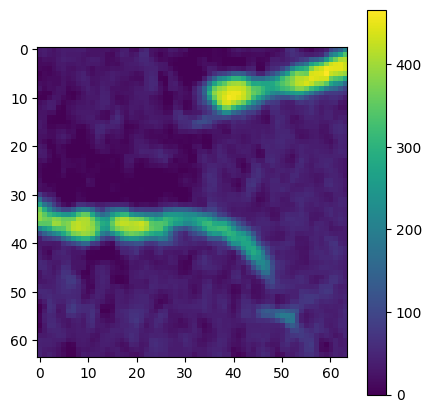

In [193]:
test_img = brain_vol[236:300, 236:300, 150:200] #175
test_img[test_img<0]=0
print_img([test_img,], (5,5))

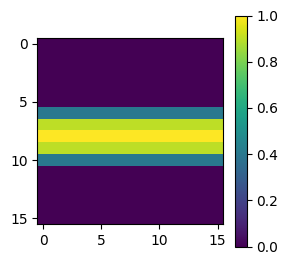

In [194]:
test_img2 = np.array([16*[0.0,],
                     16*[0.0,],
                    16*[0.0,],
                    16*[0.0,],
                    16*[0.0,],
                    16*[0.0,],
                    16*[0.4,],
                    16*[0.9,],
                    16*[1.0,],
                    16*[0.9,],
                    16*[0.4,],
                    16*[0.0,],
                    16*[0.0,],
                    16*[0.0,],
                    16*[0.0,],
                    16*[0.0,],])
print_img([test_img2,], (3,3))

In [195]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
def frangi_detect(img, sigma, k=1, alfa=1):
    H = hessian_matrix(img, sigma, use_gaussian_derivatives=False)
    eigvals = hessian_matrix_eigvals(H)
    if len(img.shape)==2:
        sorted_eigvals = eigvals[np.argsort(np.abs(eigvals[:, 0, 0]), 0)]
    if len(img.shape)==3:
        sorted_eigvals = eigvals[np.argsort(np.abs(eigvals[:, 0, 0, 0]), 0)]
        
    S3_sq = sorted_eigvals[0]**2 + sorted_eigvals[1]**2 + sorted_eigvals[2]**2 # l1^2 + l2^2 + l3^2
    Sa_sq = (sorted_eigvals[1]/sorted_eigvals[2])**2 #l2^2/l3^2
    
    out = (1 - np.exp(-Sa_sq / (2*alfa**2))) * (1 - np.exp(-S3_sq / (2*k**2)))
    return(out)    

[1.00000000e-02 2.78255940e-02 7.74263683e-02 2.15443469e-01
 5.99484250e-01 1.66810054e+00 4.64158883e+00 1.29154967e+01
 3.59381366e+01 1.00000000e+02]
[1.00000000e-02 2.78255940e-02 7.74263683e-02 2.15443469e-01
 5.99484250e-01 1.66810054e+00 4.64158883e+00 1.29154967e+01
 3.59381366e+01 1.00000000e+02]


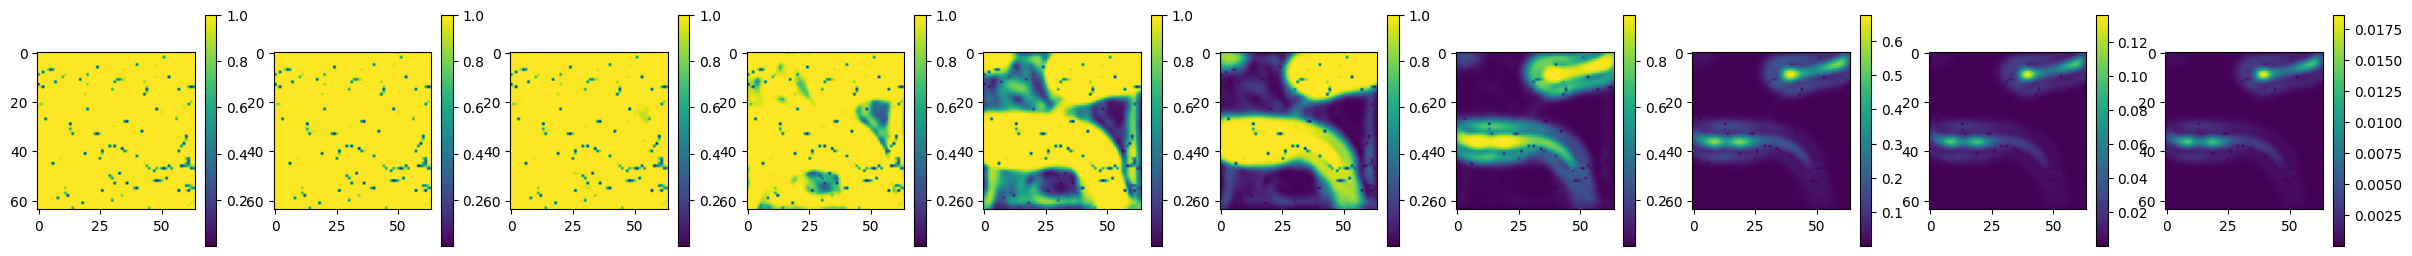

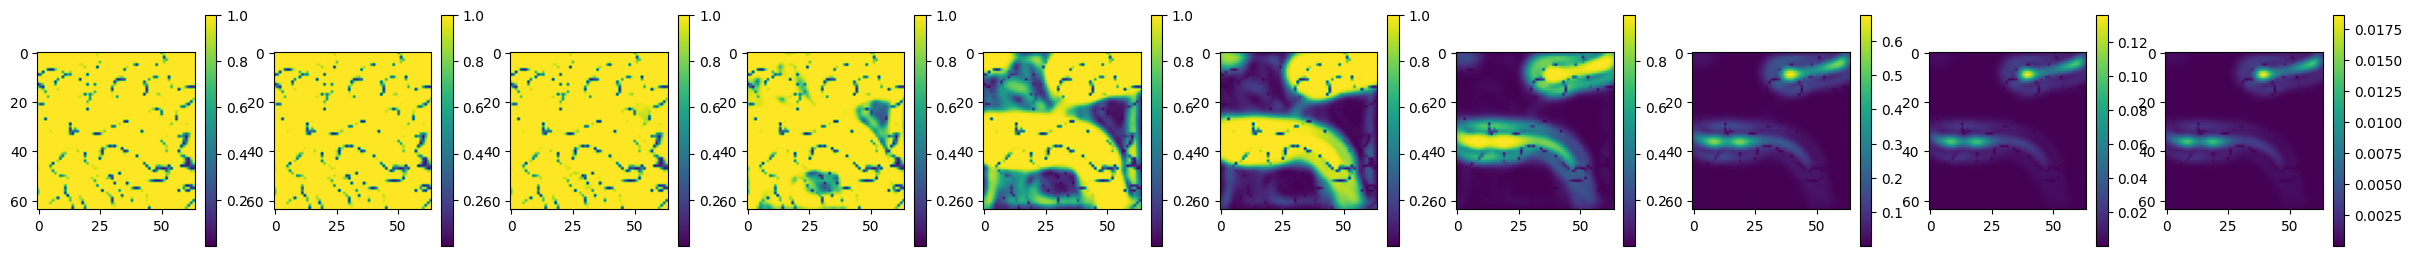

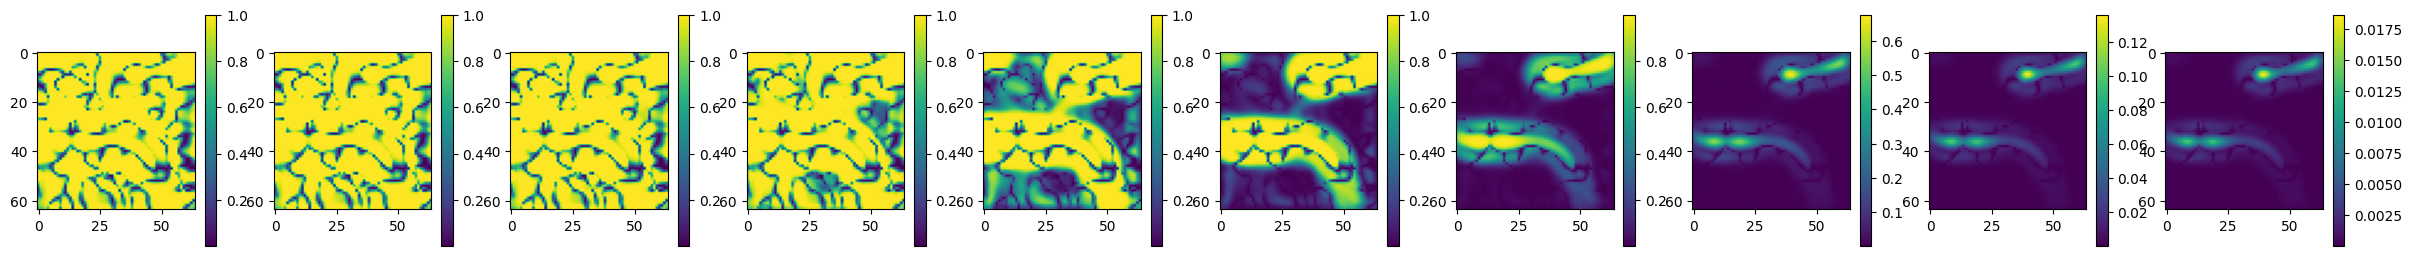

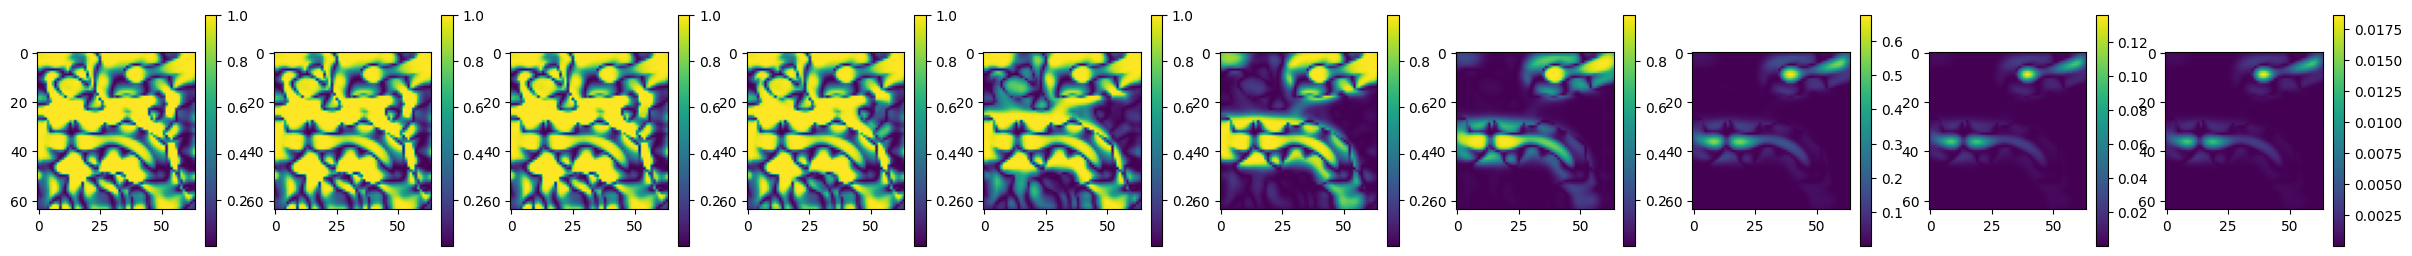

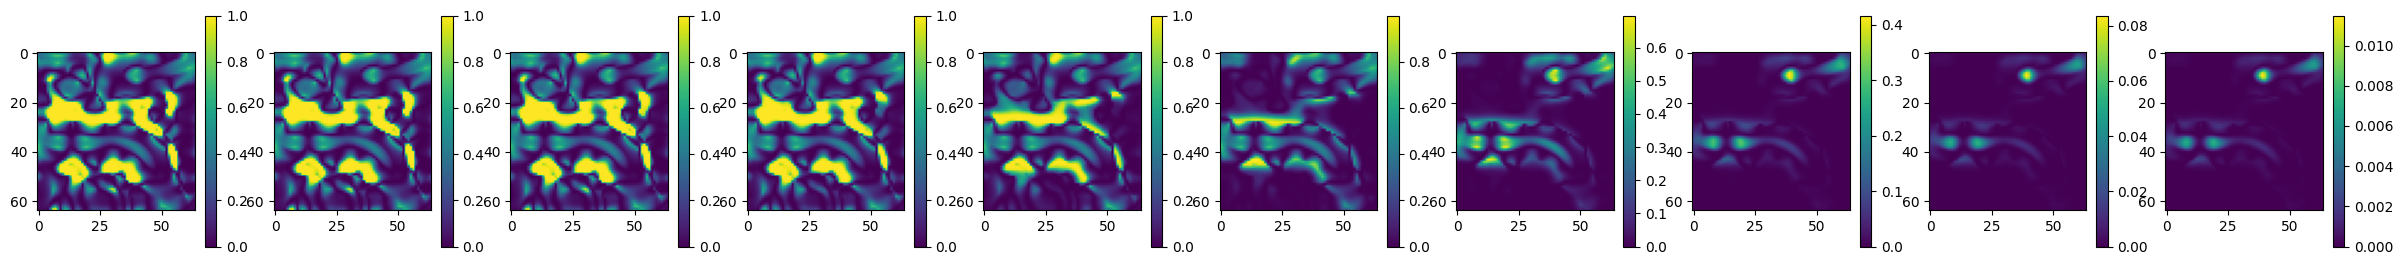

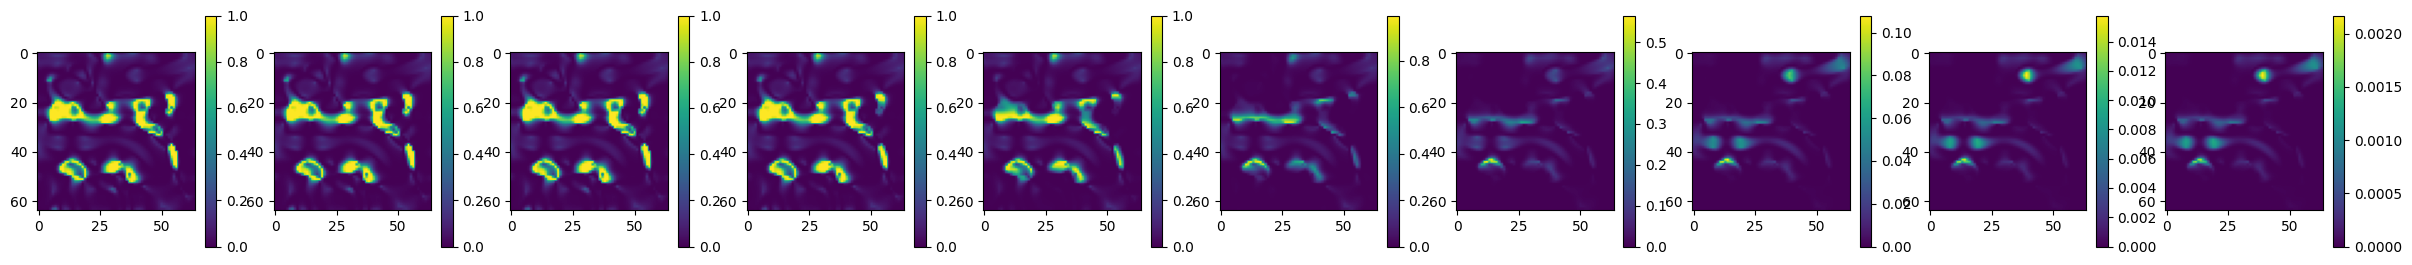

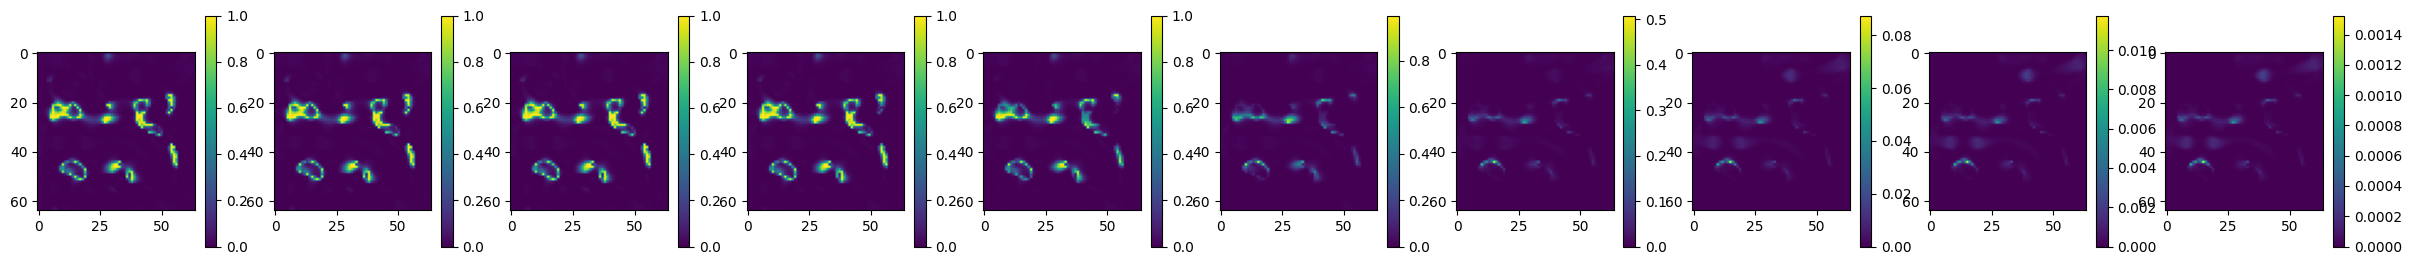

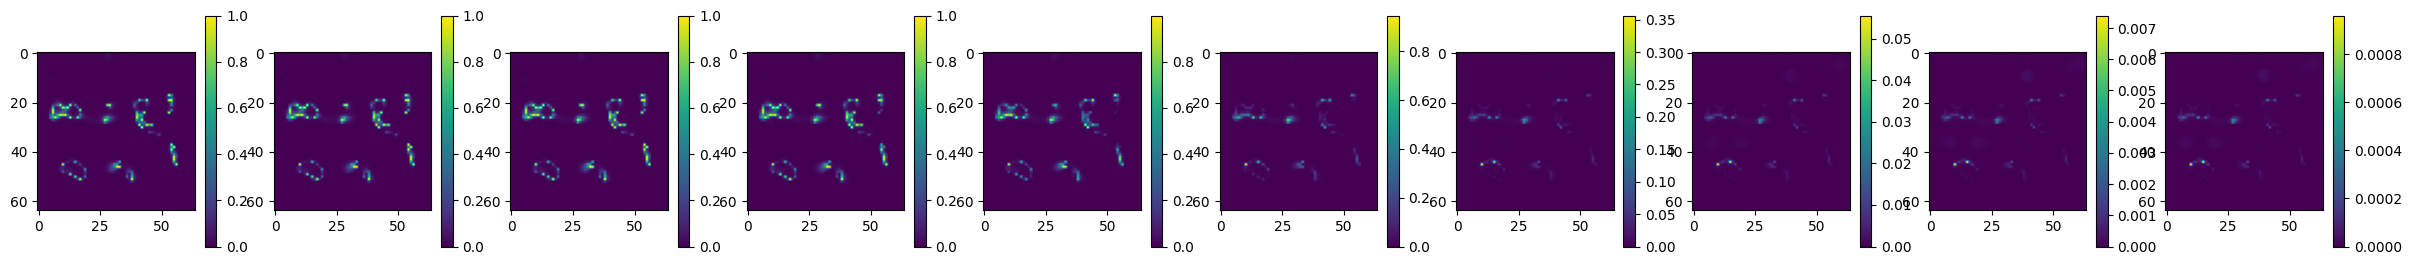

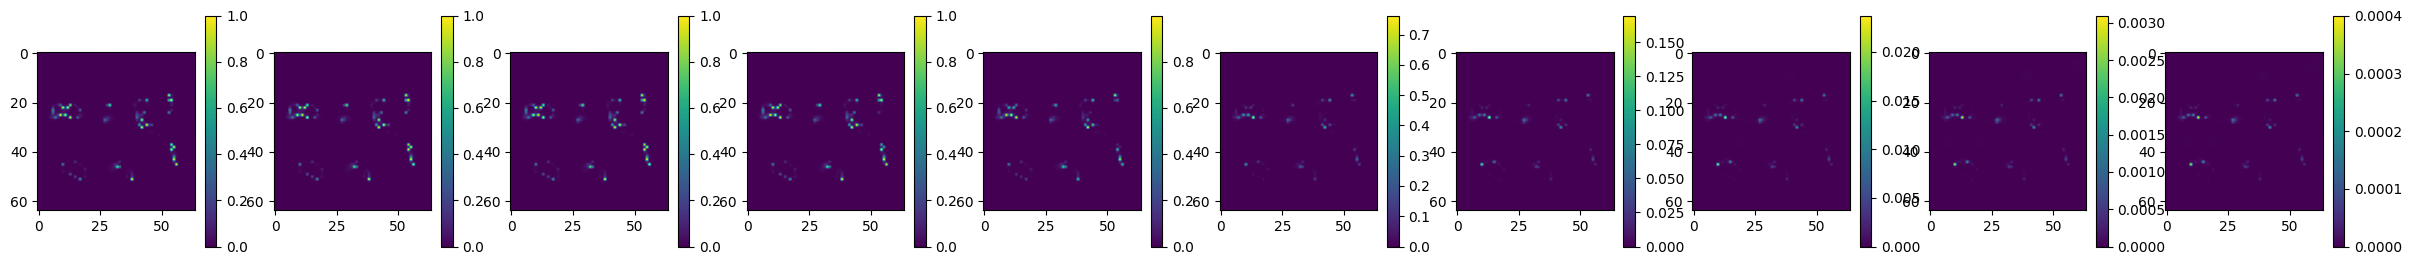

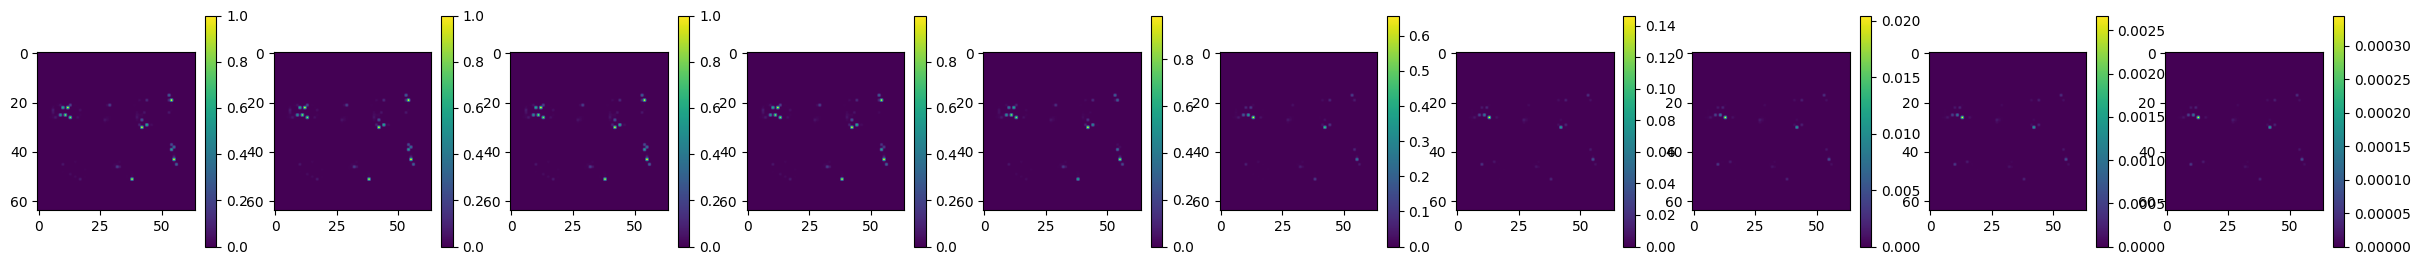

In [213]:
sigma = 3
k_range_ = np.logspace(start=-2, stop=2, num=10, base=10.0, dtype=None, axis=0)
print(k_range_)

alfa_range_ = np.logspace(start=-2, stop=2, num=10, base=10.0, dtype=None, axis=0)
print(alfa_range_)


for alfa in alfa_range_:
    outs = []
    for k in k_range_:
        out = frangi_detect(test_img, sigma=sigma, k=k, alfa=alfa)
        outs.append(out)
    print_img(outs, (3,3))

/tmp/ipykernel_2822/2778234853.py:11: RuntimeWarning: divide by zero encountered in divide
  Sa_sq = (sorted_eigvals[1]/sorted_eigvals[2])**2 #l2^2/l3^2
/tmp/ipykernel_2822/2778234853.py:11: RuntimeWarning: invalid value encountered in divide
  Sa_sq = (sorted_eigvals[1]/sorted_eigvals[2])**2 #l2^2/l3^2


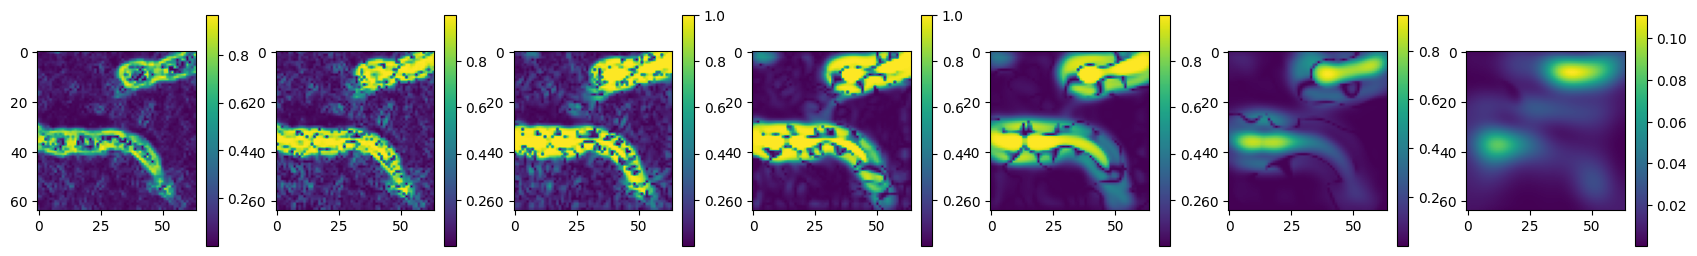

In [214]:
outs = []
for sigma in (0.3, 0.5, 1, 2, 3, 5, 10):
    out = frangi_detect(test_img, sigma=sigma, k=10/sigma, alfa=0.1)
    outs.append(out)
print_img(outs, (3,3))
    

(64, 64, 50)


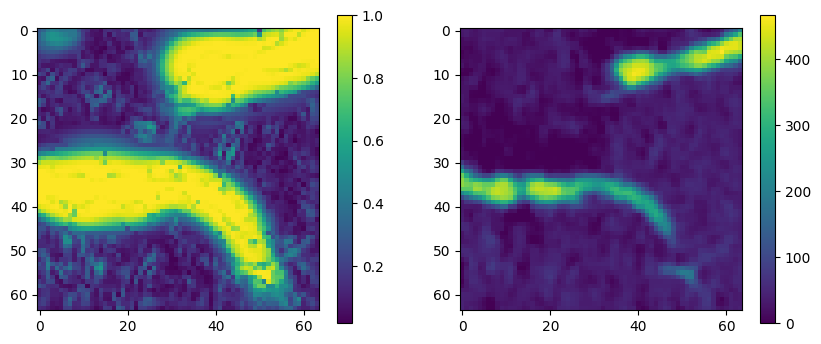

In [173]:
outs= np.array(outs)
out = outs.max(0)
print(out.shape)
print_img([out[:, :, 25], test_img[:, :, 25]])